## Dataset for work with Paul on analogs

In [1]:
import sys,os
sys.path.append('../')

# General
import glob
import os.path
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

# Arrays & Displays
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
# from matplotlib.colors import Normalize
# from matplotlib.colors import ListedColormap
import matplotlib.cm as cm
import pandas as pd

# Data treatment
import dask as da
from dask.diagnostics import ProgressBar
import zarr
from scipy.interpolate import griddata
from scipy.signal import convolve2d
from datetime import datetime

# Custom
import functions as f
# import plotUtils as pu

# Default parameters
mpl.rcParams.update({'font.size': 18})
mpl.rcParams['figure.figsize'] = (15, 10)
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = 'white'

In [2]:
PRMS = {
    'n':                5, # R+ is defined as omega(R+) = n * f
    'save_figs':        False,
}

PTHS = {
    'data_dir':         '/home/arthur/data/cyclobs/centered_rotated_files_31012022/',
    'dsg_pth':          '/home/arthur/data/cyclobs/SAR_compilations_in_nc/SAR_centered_rotated_files_13052022_with_extra_params.nc',
    'dsg2_pth':         '/home/arthur/data/cyclobs/SAR_compilations_in_nc/SAR_centered_rotated_files_17102022_with_extra_params.nc',
    'save_dir':         '/home/arthur/results/TCsLifeMonitFromObs/PRJCT_STEADY_STATE_CRIT/03_CHARAC_RADIUS/',
}

### OPEN DATA
all_data = glob.glob(PTHS['data_dir'] + "*.nc")
print("Total number of files:", len(all_data))

Total number of files: 335


In [3]:
dsg = xr.open_dataset(PTHS['dsg_pth'])

### Add intensification parameters
dsg2 = xr.open_dataset(PTHS['dsg2_pth'])
dsg['Vmax_dot_smth_IBT'] = xr.DataArray(
    data=np.array(dsg2['Vmax_dot_smth_IBT']),
    coords={'time': dsg.time}
)
dsg['Vmax_dot_IBT'] = xr.DataArray(
    data=np.array(dsg2['Vmax_dot_IBT']),
    coords={'time': dsg.time}
)
dsg['R17_dot_IBT'] = xr.DataArray(
    data=np.array(dsg2['R17_dot_IBT']),
    coords={'time': dsg.time}
)
dsg['R17_dot_smth_IBT'] = xr.DataArray(
    data=np.array(dsg2['R17_dot_smth_IBT']),
    coords={'time': dsg.time}
)

### Kinetic energy
K1_SAR = dsg['Vmax_1D'] * (dsg['Vmax_dot_smth_IBT'] * 3600) * ((dsg['R17_1D'] * 1000) ** 2)
K2_SAR = dsg['R17_1D'] * 1000 * (dsg['R17_dot_smth_IBT'] * 1000 * 3600) * (dsg['Vmax_1D'] ** 2)
K1_IBT = dsg['Vmax_IBT'] * (dsg['Vmax_dot_smth_IBT'] * 3600) * ((dsg['R34_IBT']) ** 2) 
K2_IBT = dsg['R34_IBT'] * (dsg['R17_dot_smth_IBT'] * 1000 * 3600) * (dsg['Vmax_IBT'] ** 2)

dsg['dKdt_SAR'] = K1_SAR + K2_SAR
dsg['dKdt_IBT'] = K1_IBT + K2_IBT

In [4]:
### FILTER
dsg = dsg.where(dsg.distance_to_coast > dsg.R17_1D * 1000, drop=True)
dsg = dsg.where(abs(dsg.lat_center) < 30, drop=True)
dsg = dsg.where(dsg.B_hol > 0.1, drop=True)
dsg = dsg.where(dsg.Vmax_1D > 20, drop=True)
# dsg = dsg.where(dsg.lon_center < -50, drop=True) # Keep only USA best-track agencies
# dsg = dsg.where(dsg.distance_to_coast > 200000, drop=True)
print('Nb of storms: {}'.format(len(dsg.time)))

print('SAR Mean Rmax = {:.0f} km'.format(dsg.Rmax_1D.mean()))
print('SAR Mean R64  = {:.0f} km'.format(dsg.R33_1D.mean()))

Nb of storms: 184
SAR Mean Rmax = 32 km
SAR Mean R64  = 57 km


In [5]:
# dsg[['sat_file', 'storm_id']].astype(str).to_netcdf('/home/arthur/Téléchargements/dsg.nc')

### Characteristic radius R+

In [6]:
def coriolis(lat):
    '''Latitude must be in degrees.'''
    Omega = 7.2921e-5                            # Earth rotation vector
    fcor  = 2 * Omega * np.sin(lat * np.pi / 180) # Coriolis parameter at 20° latitude and assuming it's constant 
    return fcor

def holland_profile(r, lat, pn, pc, Vmin, Rmax, Vmax):
    '''We assume that rho is constant and equals 1.15 kg.m-3'''
    fcor  = abs(coriolis(lat))
    rho   = 1.15
    # B     = (Vmax ** 2) * rho * np.e / (pn - pc)
    B     = ((Vmax - Vmin) ** 2) * rho * np.e / (pn - pc)
    A     = Rmax ** B
    
    r     = r.astype(np.float) + 0.001 # To avoid dividing by zero
    V     = r * 0.
    V     = Vmin + np.sqrt(A * B * (pn - pc) * np.exp((-1) * A / (r ** B)) / (rho * r ** B) + (r ** 2 * fcor ** 2) / 4) - (r * fcor / 2)
    return V

rs = np.linspace(0, 500000, 50001) # define dr accordingly
def vorticity(r, v):
    '''Relative vorticity'''
    dr = 10 # meters
    return (1 / r) * np.gradient(r * v, dr)

In [7]:
rs  = np.linspace(0, 500000, 50001)
n   = PRMS['n']
DSs = dsg.mean(dim='theta', skipna=True)

# Initialize
DSs['R_plus'] = DSs['Vmax_1D'].copy(deep=True) * np.nan
DSs['V_plus'] = DSs['Vmax_1D'].copy(deep=True) * np.nan

for t in tqdm(np.arange(len(DSs.time))):
    ds       = DSs.isel(time=t)
    Vh       = holland_profile(rs, float(abs(ds.lat_center)), float(ds.pn_hol), float(ds.pc_hol), float(ds.Vmin_hol), float(ds.Rmax_hol), float(ds.Vmax_hol))
    rm       = float(ds.Rmax_hol)
    out      = rs > rm                             # To find outer-core
    r        = rs[out]
    vrt      = vorticity(rs, Vh)[out]              # Relative vorticity
    vrt_plan = float(abs(coriolis(ds.lat_center))) # Planetary vorticity
    
    # # Plot vertical velocity
    # q  = r * (Vh[out] ** 2) / (vrt + vrt_plan)
    # Cd = 2e-5
    # dr = 10 # meters
    # we = (Cd / r) * np.gradient(q, dr)
    # plt.plot(we, c='gray', alpha=0.25)
    # plt.ylim(-0.001, 0.01)
    
    try: 
        R_plus =  r[abs(vrt - n * vrt_plan) < 1e-7][0] 
        V_plus = ds.sel(rad=slice(R_plus - 500, None)).wind_speed[0]
    except IndexError:
        R_plus = V_plus = np.nan
    
    DSs['R_plus'][t] = R_plus
    DSs['V_plus'][t] = V_plus

100%|████████████████████████████████████████| 184/184 [00:01<00:00, 102.23it/s]


#### Compute Rmax CK22A23

In [8]:
def M(f, r, V):
    '''Definition of angular momentum. 
    CAVEAT: R is in meters, V in m/s. 
    If V is total wind speed, then take abs(f)'''
    return r * V + 0.5 * f * (r ** 2)

def Rmax_from_M(fcor, Mmax, Vmax):
    return (Vmax / fcor) * (np.sqrt(1 + (2 * fcor * Mmax) / (Vmax ** 2)) - 1)

# def correct_vmx_ibt(vmx_ibt):
#     return 0.6967 * vmx_ibt + 6.1992

In [9]:
# Prepare dataset
vmx  = DSs.Vmax_1D
r34  = DSs.R17_1D * 1000
r50  = DSs.R26_1D * 1000
r64  = DSs.R33_1D * 1000
fcor = abs(coriolis(DSs.lat_center))

# Compute the momentum ratios
Mm_M34 = 0.531 * np.exp(
    -0.00214 * (vmx - 17.5)
    -0.00314 * (vmx - 17.5) * 0.5 * fcor * r34
)

Mm_M50 = 0.626 * np.exp(
     0.00282 * (vmx - 25.7)
    -0.00724 * (vmx - 25.7) * 0.5 * fcor * r50
)

Mm_M64 = 0.612 * np.exp(
     0.00946 * (vmx - 32.9)
    -0.01183 * (vmx - 32.9) * 0.5 * fcor * r64
)

# Compute Mmax
Mm_with_r34 = Mm_M34 * M(fcor, r34, 17.5)
Mm_with_r50 = Mm_M50 * M(fcor, r50, 25.7)
Mm_with_r64 = Mm_M64 * M(fcor, r64, 32.9)

# Compute Rmax_CK22A23
Rm_with_r34 = Rmax_from_M(fcor, Mm_with_r34, vmx) / 1000
Rm_with_r50 = Rmax_from_M(fcor, Mm_with_r50, vmx) / 1000
Rm_with_r64 = Rmax_from_M(fcor, Mm_with_r64, vmx) / 1000

# Include
DSs['rmx_ck22'] = Rm_with_r34.copy(deep=True)
DSs['rmx_ck22'][Rm_with_r50.notnull()] = Rm_with_r50.copy(deep=True)[Rm_with_r50.notnull()]
DSs['rmx_ck22'][Rm_with_r64.notnull()] = Rm_with_r64.copy(deep=True)[Rm_with_r64.notnull()]

#### Save dataset

In [10]:
## DATASET FOR PAUL

### Computing Kinetic Energy
V34         = 17.5 # m/s
g           = 9.8  # m/s^2
rho         = 1.15 # kg/m^3
theta_ratio = 1e-2 # []

# Below, dK/dt is expressed in J/hr, where 1J = 1 kg m^2 s^-2
DSs['dKdt'] = (rho * V34 ** 2 / (g * theta_ratio)) * 2 * (DSs['R17_1D'] * 1000 * DSs['Vmax_1D']) * ((DSs['Vmax_dot_smth_IBT']) * (DSs['R17_1D'] * 1000) + (DSs['R17_dot_smth_IBT'] * 1000) * DSs['Vmax_1D'])
nrm         = 1e15
DSs['dKdt'] = DSs['dKdt'] / nrm # now in PJ/hr

# Save data
vars2drop               = ['interpolated_track_point', 'eye_center', 'lon_eye_c', 'lat_eye_c', 'lon_trk_c', 'lat_trk_c', 'storm_name', 'storm_id', 'sat_file', 'sat_pth']
DSs_clean               = DSs.drop_vars(vars2drop)
DSs_clean['storm_name'] = DSs['storm_name'].astype(str)
DSs_clean['storm_id']   = DSs['storm_id'].astype(str)
DSs_clean['sat_file']   = DSs['sat_file'].astype(str)
DSs_clean['sat_pth']    = DSs['sat_pth'].astype(str)

# Save
# DSs_clean.to_netcdf(PTHS['save_dir'] + 'dsg_rpls.nc')

In [ ]:
DSs_clean.where(DSs_clean.storm_name == 'OLIVIA', drop=True)

<xarray.Dataset>
Dimensions:             (time: 2, rad: 500, dim_0: 5)
Coordinates:
  * time                (time) datetime64[ns] 2018-09-10T15:52:41 2018-09-08T...
  * rad                 (rad) float64 0.0 1e+03 2e+03 ... 4.98e+05 4.99e+05
Dimensions without coordinates: dim_0
Data variables: (12/88)
    wind_speed          (time, rad) float64 10.7 10.78 11.21 ... nan nan nan
    track_vmax          (time) float64 35.0 39.0
    distance_to_coast   (time) float64 7.567e+05 1.76e+06
    cyclone_speed       (time) float64 3.454 6.993
    cyclone_speed_std   (time) float64 0.2306 0.2236
    rotation_angle      (time) float64 87.91 78.05
    ...                  ...
    rmx_ck22            (time) float64 14.48 25.23
    dKdt                (time) float64 -1.226 -0.5834
    storm_name          (time) object 'OLIVIA' 'OLIVIA'
    storm_id            (time) object 'ep172018' 'ep172018'
    sat_file            (time) object 'rs2--owi-cm-20180910t155203-20180910t1...
    sat_pth             (time) object '/home/arthur/data/cyclobs/centered_rot...

In [19]:
p = '/home/arthur/data/ibtracs/IBTrACS.NA.v04r00.nc'

In [20]:
a = xr.open_dataset(p)

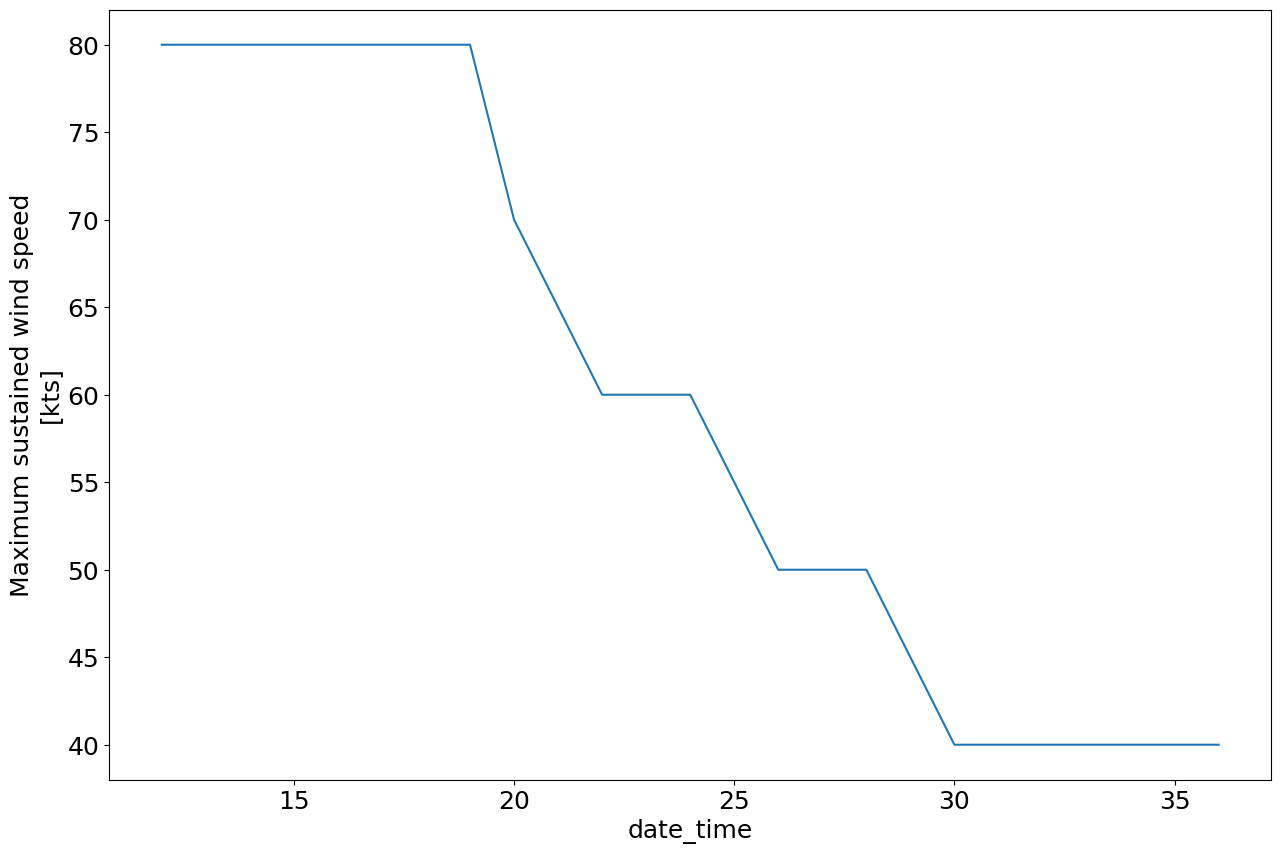

In [31]:
a.isel(storm=0).usa_wind.plot()